# Spotlight on Deep Graph Library (DGL)

--Shibo Wang

## Introduction

Deep Graph Library (DGL) is a Python package built for easy implementation of graph neural network model family, on top of existing DL frameworks (e.g. PyTorch, MXNet, Gluon, etc.). This spotlight will introduce some basic operations of DGL and help you understand how DGL handles nodes and edges in a graph from a high level. After that, we will implement the conventional PageRank models with DGL Message Passing from a new graphical perspective yielding simplicity.

## Installation

First, you should install DGL, then import this library. You can find more installation details on https://docs.dgl.ai/install/index.html. For me, I install GPU builds with CUDA 10.0, so I use the command "pip install dgl-cu100".

In [50]:
import dgl

## Step 1: Creating a graph in DGL

The first step is to build a graph and do read/write operations on nodes and edges. Here we can simply create a graph using networkx and use the API in DGL to transfer this graph into DGL style. In this example, we build a Petersen graph which has 10 nodes and 15 edges.

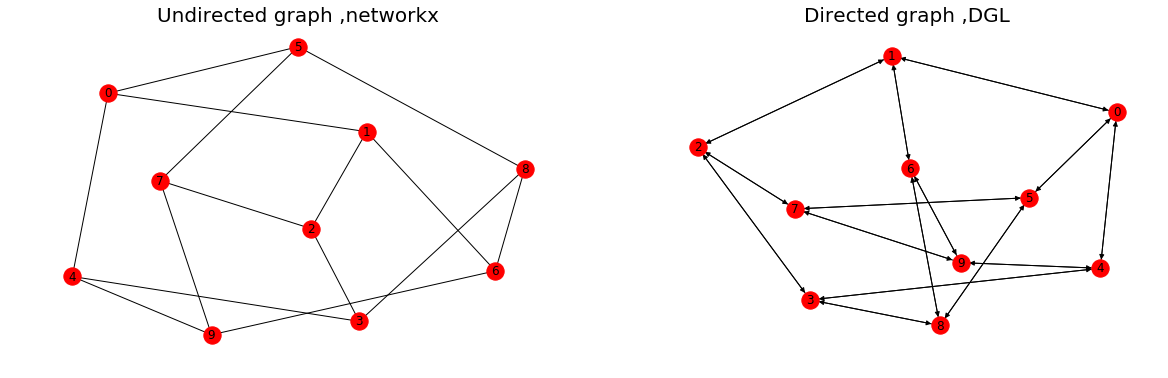

In [51]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt


# create a petersen grpah
g_nx = nx.petersen_graph()
# input networkx grpah ,return DGL graph
g_dgl = dgl.DGLGraph(g_nx)  # add direction,bidirectional

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.title('Undirected graph ,networkx',fontsize=20)
nx.draw(g_nx, with_labels=True)
plt.subplot(122)
plt.title('Directed graph ,DGL', fontsize=20)
nx.draw(g_dgl.to_networkx(), with_labels=True)


In this example, we can build a graph directly using DGL. DGLGraph nodes are a consecutive range of integers from 0 to number_of_nodes() and can grow by calling add_nodes. DGLGraph edges are in order of their additions. The code below shows how to add nodes and edges.

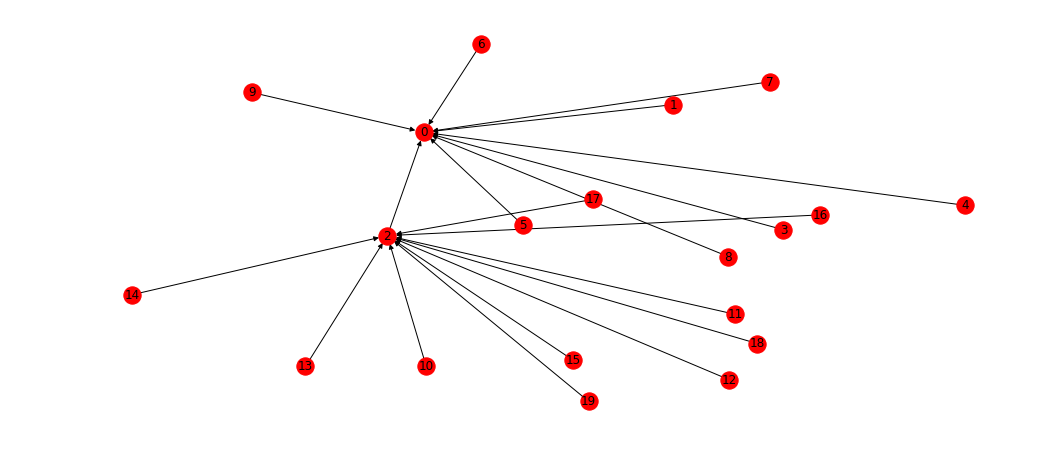

In [52]:
import dgl
import torch as th
import networkx as nx
import matplotlib.pyplot as plt

g = dgl.DGLGraph()
g.add_nodes(20)
# Add edges one by one
for i in range(1, 10):
    g.add_edge(i, 0)
# Add a group of edges
src = list(range(10, 20)); dst = [2]*10
g.add_edges(src, dst)

plt.figure(figsize=(14, 6))
nx.draw(g.to_networkx(), with_labels=True)


Use edge broadcasting to build a star graph in one go.

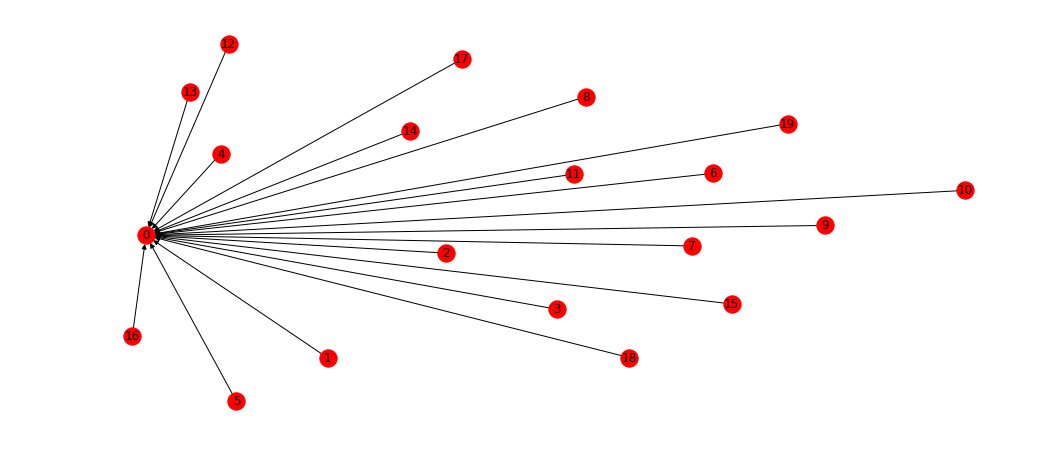

In [53]:
g.clear()
g.add_nodes(20)
src = th.tensor(list(range(1, 20)))
g.add_edges(src, 0)
plt.figure(figsize=(14, 6))
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

## Step 2: Assign features to nodes and edges

We can also assign features to nodes and edges of a DGLGraph. These features are represented as a dictionary of names and tensors, called fields.

In [54]:
#Assign features to nodes
import dgl
import torch as th

x = th.randn(20, 3)
g.ndata['x'] = x
print(g.nodes[:].data['x'])

tensor([[ 0.2255,  0.7496,  0.8036],
        [ 0.2760,  0.5157,  0.2911],
        [-0.6245, -0.8061, -0.8090],
        [ 1.7021, -0.3568,  0.2382],
        [-0.1629, -0.0603, -0.1596],
        [ 0.0273,  0.7004,  0.4971],
        [-0.7067,  0.9543,  0.2825],
        [ 0.5589,  0.6614,  1.1460],
        [-1.4173,  0.0605, -2.7811],
        [-0.8428, -1.4610, -0.0950],
        [ 0.7453, -0.8361,  1.0443],
        [ 1.2800,  1.1992, -0.8447],
        [-1.3480,  0.9698, -0.7779],
        [-1.2461,  1.1011,  0.8167],
        [ 0.3705,  0.0524, -0.0298],
        [-0.4932,  0.1916,  0.2773],
        [-1.9619,  0.2436, -1.0153],
        [-0.2990, -0.8832, -0.6815],
        [ 0.1752, -0.3509, -0.3474],
        [-0.6503, -0.1559,  0.7116]])


In [55]:
# Access node
g.nodes[0].data['x'] = th.zeros(1, 3)
g.nodes[[1,2,3]].data['x'] = th.zeros(3, 3)
g.nodes[th.tensor([4,5,6])].data['x'] = th.zeros(3, 3)
print(g.nodes[:].data['x'])

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.5589,  0.6614,  1.1460],
        [-1.4173,  0.0605, -2.7811],
        [-0.8428, -1.4610, -0.0950],
        [ 0.7453, -0.8361,  1.0443],
        [ 1.2800,  1.1992, -0.8447],
        [-1.3480,  0.9698, -0.7779],
        [-1.2461,  1.1011,  0.8167],
        [ 0.3705,  0.0524, -0.0298],
        [-0.4932,  0.1916,  0.2773],
        [-1.9619,  0.2436, -1.0153],
        [-0.2990, -0.8832, -0.6815],
        [ 0.1752, -0.3509, -0.3474],
        [-0.6503, -0.1559,  0.7116]])


In [56]:
#Assign features to edges
g.edata['w'] = th.randn(19, 2)

# Access edges
g.edges[1].data['w'] = th.randn(1, 2)
g.edges[[2, 3, 4]].data['w'] = th.zeros(3, 2)
g.edges[th.tensor([5, 6, 7])].data['w'] = th.zeros(3, 2)
# Access edges via nodes on tow ends
g.edges[1, 0].data['w'] = th.ones(1, 2)                 # edge 1 -> 0
g.edges[[1, 2, 3], [0, 0, 0]].data['w'] = th.ones(3, 2) # edges [1, 2, 3] -> 0

# shape,type
g.ndata['x'] = th.zeros((20, 4))
print(g.node_attr_schemes())

{'x': Scheme(shape=(4,), dtype=torch.float32)}


In [57]:
# We can also remove node or edge features from the graph like operations in python dictionary
g.ndata.pop('x')
g.edata.pop('w')

tensor([[ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.6307,  1.6277],
        [-0.7416, -1.8059],
        [ 0.9156, -0.9563],
        [ 0.1323, -1.7917],
        [-0.2423,  0.4800],
        [-0.4419,  1.5061],
        [-0.5201,  0.1148],
        [-1.0635, -0.5241],
        [ 0.1219,  0.9207],
        [ 1.5557,  0.3150],
        [-0.1686, -0.5266]])

## Step 3: Implement PageRank with DGL message passing

In this example, we will use different levels of the message passing API with PageRank on our homework 2 graph and compare these results. When you use the code, please make the data file "HITS.json" in the same directory.

In [104]:
#Build the graph in homework 2
import dgl
import json, pickle
from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix

def buildGraph(path):
    tweets = []
    for line in open(path,encoding='utf-8', mode = 'r'):
        tweets.append(json.loads(line))
    #print(len(tweets))

    myGraph = defaultdict(set)
    for tweet in tweets:
        # If a user retweets herself, ignore it.
        if tweet['user']['id'] != tweet['retweeted_status']['user']['id']:
            #If Bob retweets Alice once, in 10 tweets, or 10 times in one tweet, there is an edge from Bob to Alice, so we use set to record edges instead of dict
            myGraph[tweet['user']['id']].add(tweet['retweeted_status']['user']['id'])
            if tweet['retweeted_status']['user']['id'] not in myGraph:
                myGraph[tweet['retweeted_status']['user']['id']] = set()
    
    gdict = {}
    
    g = dgl.DGLGraph()
    g.add_nodes(len(myGraph))
    i = 0
    for key in myGraph:
        gdict[i] = key
        gdict[key] = i
        i += 1
    # Add edges one by one
    for key in myGraph:
        for node in myGraph[key]:
            g.add_edge(gdict[key], gdict[node])
        
    return g, gdict

In [105]:
path = "./HITS.json"
g, gdict = buildGraph(path)

In [106]:
print(g)

DGLGraph(num_nodes=1003, num_edges=6177,
         ndata_schemes={}
         edata_schemes={})


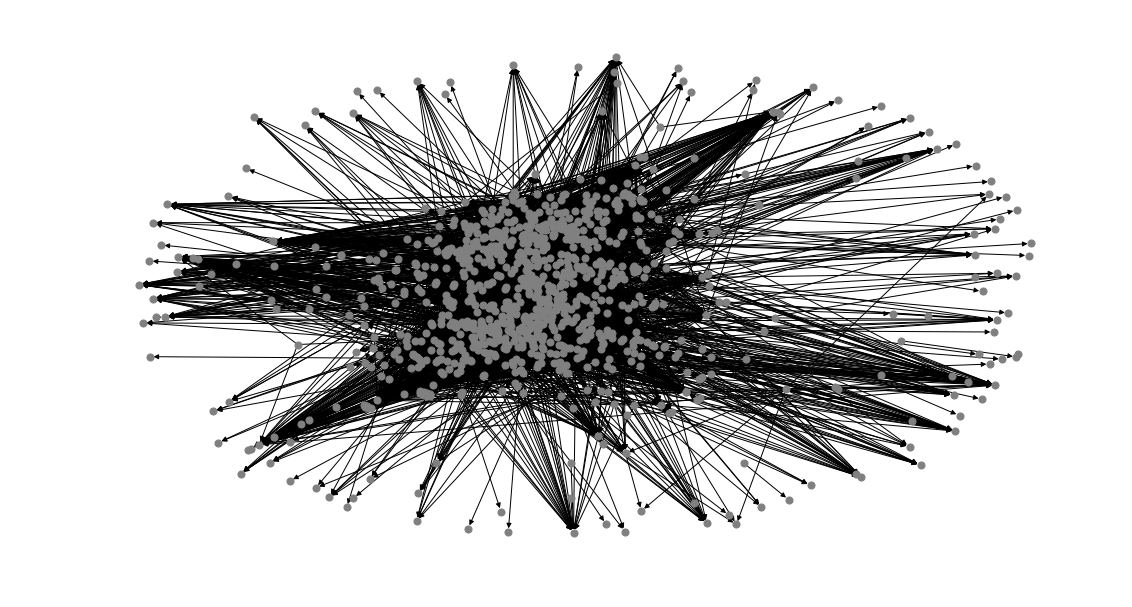

In [24]:
#Visualize this graph
plt.figure(figsize=(15, 8))
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])

In [108]:
import torch

def pagerank1(g, DAMP, maxerr):

    # Assign Features to nodes
    N = g.number_of_nodes()
    #1/N value
    g.ndata['pr'] = torch.ones(N)# / N
    #out degree
    g.ndata['od'] = g.out_degrees(g.nodes()).float()

    
    #Define the message function, which divides every node's PageRank value by its out-degree and passes the result as message to its neighbors.
    def pagerank_message_func(edges):
        return {'pr' : edges.src['pr'] / edges.src['od']}
    
    #Define the reduce function, which removes and aggregates the messages from its mailbox, and computes its new PageRank value.
    def pagerank_reduce_func(nodes):
        msgs = torch.sum(nodes.mailbox['pr'], dim=1)
        pv = (1 - DAMP) / N + DAMP * msgs
        return {'pr' : pv}

    ## register
    g.register_message_func(pagerank_message_func)
    g.register_reduce_func(pagerank_reduce_func)
    
    #for _ in range(30):
    r0, r = torch.zeros(N), torch.ones(N)
    iteration = 0
    while torch.sum(torch.abs(r0 - r)) > maxerr:
        iteration += 1
        # Phase #1: send out messages
        for u, v in zip(*g.edges()):
            g.send((u, v))
        # Phase #2: compute, update new PageRank values.
        for v in g.nodes():
            g.recv(v)
            
        r0[:] = r[:]
        r[:] = g.nodes[:].data['pr']
        #print(torch.sum(torch.abs(r0 - r)))
        
    print("iteration = ", iteration)
    res = []
    for i in range(g.number_of_nodes()):
        res.append([gdict[i], g.nodes[i].data['pr'].item()])
    res.sort(key = lambda x : -x[1])
    print("Top 10 of users and their scores are ")
    for i in range(10):
        print('{} - {} '.format(res[i][0], res[i][1]))

In [109]:
pagerank1(g, 0.9, 0.01)

iteration =  45
Top 10 of users and their scores are 
1183906148 - 53.203704833984375 
3019659587 - 52.80598449707031 
3077695572 - 51.97382736206055 
3068694151 - 45.26909637451172 
571198546 - 44.78701400756836 
3042570996 - 44.288509368896484 
3039321886 - 41.125511169433594 
3154266823 - 35.9472770690918 
3082766914 - 35.07306671142578 
2598548166 - 34.47317123413086 


We can also use DGL builtin functions for efficiency. The above code does not scale to a large graph because it iterates over all the nodes. And now we would like to perform message passing on all nodes in parallel. Here we can use level-2 APIs in DGL. And we get the same result.

In [112]:
import dgl.function as fn

def pagerank2(g, DAMP, maxerr):
    N = g.number_of_nodes()
    r0, r = torch.zeros(N), torch.ones(N)
    iteration = 0
    while torch.sum(torch.abs(r0 - r)) > maxerr:
        iteration += 1
        g.ndata['pr'] = g.ndata['pr'] / g.ndata['od']
        g.update_all(message_func=fn.copy_src(src='pr', out='m'),
                     reduce_func=fn.sum(msg='m',out='m_sum'))
        g.ndata['pr'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']
        
        r0[:] = r[:]
        r[:] = g.nodes[:].data['pr']
        
    print("iteration = ", iteration)
    res = []
    for i in range(g.number_of_nodes()):
        res.append([gdict[i], g.nodes[i].data['pr'].item()])
    res.sort(key = lambda x : -x[1])
    print("Top 10 of users and their scores are ")
    for i in range(10):
        print('{} - {} '.format(res[i][0], res[i][1]))

In [114]:
pagerank1(g, 0.9, 0.01)

iteration =  45
Top 10 of users and their scores are 
1183906148 - 53.203704833984375 
3019659587 - 52.80598449707031 
3077695572 - 51.97382736206055 
3068694151 - 45.26909637451172 
571198546 - 44.78701400756836 
3042570996 - 44.288509368896484 
3039321886 - 41.125511169433594 
3154266823 - 35.9472770690918 
3082766914 - 35.07306671142578 
2598548166 - 34.47317123413086 
